*Reference*<br>
https://www.youtube.com/watch?v=WgsZc_wS2qQ

In [ ]:
'''
brew install libomp (for OSX)
pip install torchtext -U
'''
import torch
import torchvision
from torchvision import models
import torchvision.transforms as T

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

print('pytorch', torch.__version__)
print('torchvision', torchvision.__version__)

pytorch 1.5.1+cu101
torchvision 0.6.1+cu101


In [ ]:
IMG_SIZE = 480

COLORS = np.array([
    (0, 0, 0),       # 0=background
    (128, 0, 0),     # 1=aeroplane
    (0, 128, 0),     # 2=bicycle
    (128, 128, 0),   # 3=bird
    (0, 0, 128),     # 4=boat
    (128, 0, 128),   # 5=bottle
    (0, 128, 128),   # 6=bus
    (128, 128, 128), # 7=car
    (255, 255, 255), # 8=cat
    (192, 0, 0),     # 9=chair
    (64, 128, 0),    # 10=cow
    (192, 128, 0),   # 11=dining table
    (64, 0, 128),    # 12=dog
    (192, 0, 128),   # 13=horse
    (64, 128, 128),  # 14=motorbike
    (192, 128, 128), # 15=person
    (0, 64, 0),      # 16=potted plant
    (128, 64, 0),    # 17=sheep
    (0, 192, 0),     # 18=sofa
    (128, 192, 0),   # 19=train
    (0, 64, 128)     # 20=tv/monitor
])

# Download Model

In [ ]:
deeplab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


# Load Image

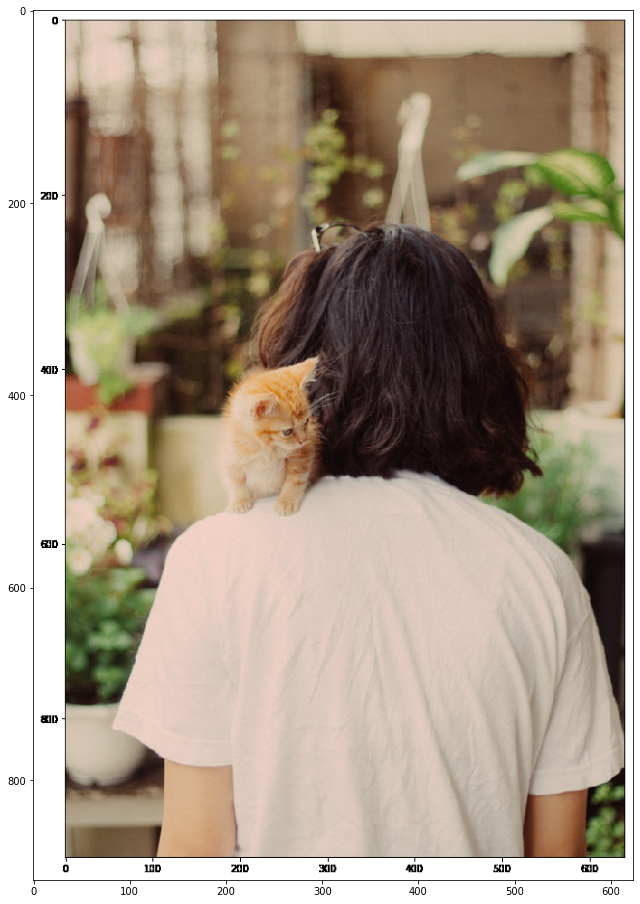

In [ ]:
img = Image.open('03.jpg').convert('RGB')

plt.figure(figsize=(16, 16))
plt.imshow(img)

# Image to Tensor
* T.Resize(256) : Resizes the image to size width 256
* T.CenterCrop(224) : Center Crops the image to have a resulting size of 224 x 224
* T.ToTensor() : Converts the image to type torch.Tensor and have values between [0, 1]
* T.Normalize(mean, std) : Normalizes the image with the given mean and standard deviation.

In [ ]:
# T.Resize(): 이미지를 해당 크기로 변형한다(가로 세로 비율 유지)

trf = T.Compose([
    T.Resize(IMG_SIZE),
#     T.CenterCrop(IMG_SIZE), # make square image
    T.ToTensor(), 
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 3x695x480 --> 1x3x695x480
input_img = trf(img).unsqueeze(0)

# Inference
* [1, 21, 256, 256]
* 1: batch_size
* 21: classes
* 256, 256: image size

In [ ]:
out = deeplab(input_img)['out']

print(out.shape)

torch.Size([1, 21, 695, 480])


# Extract Class Map

In [ ]:
# tensor.squeez(): shape이 1인 axis를 삭제한다
# (1, 21, 695, 480) --> (21, 695, 480)
out = torch.argmax(out.squeeze(), dim=0)
out = out.detach().cpu().numpy()

print(out.shape)
print(np.unique(out))   # np.unique(): 배열에서 유일한 값을 뽑아낸다

(695, 480)
[ 0  8 15 16]


# Class Map to Segmentation Map

In [ ]:
def seg_map(img, n_classes=21):
    # np.zeros(): 0으로 채운 shape 형태의 배열을 생성한다
    rgb = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    for c in range(n_classes):
        idx = img == c

        rgb[idx] = COLORS[c]

    return rgb

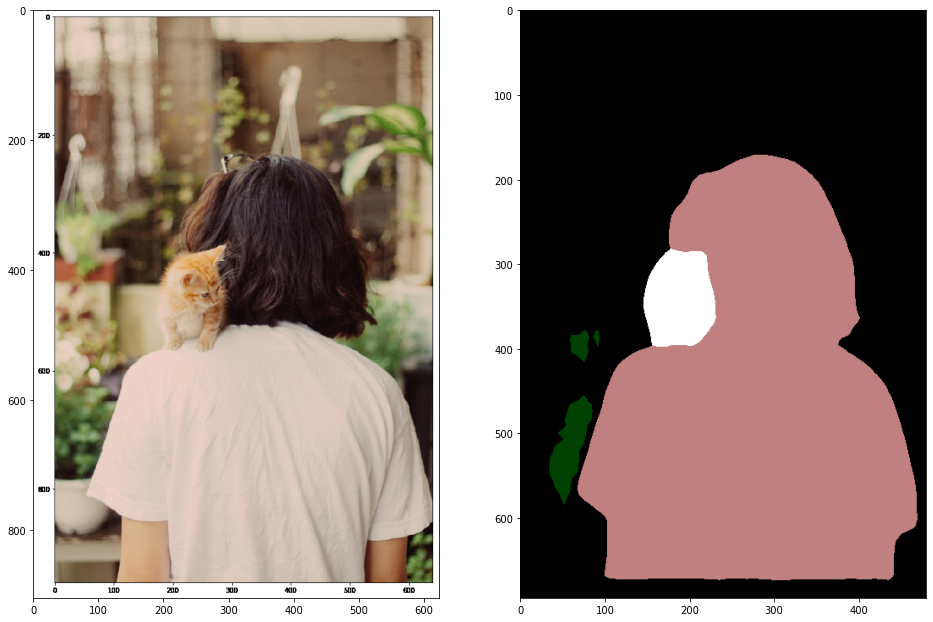

In [ ]:
out_seg = seg_map(out)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
ax[0].imshow(img)
ax[1].imshow(out_seg)